In [42]:
import pandas as pd
import numpy as np
import datetime
import pandas as pd
import numpy as np
import os
import pytz
import json
import random
import time
from tqdm import tqdm
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.drawing.image import Image
from DCP_Understanding import SetDataFrame
from DCP_Visualization import SetGraph
from DCP_Utils import *

KST = pytz.timezone('Asia/Seoul')
datetime.datetime.now(KST)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)


TABLE = {'ACCOUNT_TRANS':'계좌거래정보',
         'CARD_PAYMENTS':'카드결제',
         'PRECARD_PAYMENTS':'선불카드결제',
         'PAY_TRANS':'페이거래정보',
         'CONNECT_PAYMENTS':'페이연결계좌(카드)결제',
         'CHARGE_PAYMENTS':'페이충전결제',
         'TELECOMS_TRANS':'통신거래',
         }
COMPANY = {'nicbank':'닉컴은행',}



<ipython-input-42-662d9ee36541>:25: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [43]:
#### input
path = "../../data/"
table = 'ACCOUNT_TRANS'
result_report_file_path = "../../data/result/%s_report_example.csv"%table
company = "닉컴퍼니"
today = datetime.datetime.now().strftime('%Y-%m-%d')
nowtime = datetime.datetime.now().strftime('%H:%M:%S')
user = "NIC"

In [44]:
ci = pd.read_csv("../../data/ci_info.csv", encoding="cp949", index_col=0)
stat = pd.read_csv("../../data/nicbank_stat.csv", encoding="cp949", index_col=0)
code = pd.read_csv("../../data/nicbank_code.csv", encoding="cp949", index_col=0)

In [45]:
### ci와 데이터 merge
df = pd.read_csv(os.path.join(path, table+".csv"), encoding="cp949", index_col=0)
df = pd.merge(ci, df, on='ci_num', how='right')

# table_columns = stat[stat['col_table']==table]['col_name'].tolist()
# df.rename(columns={i:n for i, n in enumerate(table_columns)}, inplace=True)

df.head()

,ci_num,ci_age,ci_gender,kor_types,account_num,account_org_code,account_currency_code,account_trans_dtime,account_trans_type,trans_class,account_trans_amt,account_balance_amt,account_trans_memo,customer_types,other_org_code,other_account_num,trans_class_code,device_types,org_types,my_account_code,account_country_code
0,2222222222222222222222222222222222222222222222222222222222222222222222222222222222222222,30,1,1,110-500-801845,신한은행,KRW,2021-12-24 10:15:58,3,타행IB,2000000,3322155,급여,1,NaN,394-5648-3327-55,2,4,2,2,245
1,2222222222222222222222222222222222222222222222222222222222222222222222222222222222222222,30,1,1,110-500-801845,신한은행,KRW,2021-12-21 11:43:53,3,타행환,5000,1021175,씨티카드연회비,1,NaN,653-7742-3257-85,2,4,2,2,228
2,2222222222222222222222222222222222222222222222222222222222222222222222222222222222222222,30,1,1,110-500-801845,신한은행,KRW,2021-12-18 02:06:41,3,이자,254,1057375,09.18~12.17,1,NaN,571-98-229421,7,6,2,2,191
3,2222222222222222222222222222222222222222222222222222222222222222222222222222222222222222,30,1,1,110-500-801845,신한은행,KRW,2021-12-15 08:22:30,3,타행IB,260000,1798001,최광우,1,NaN,712-19-975497,3,1,2,2,20
4,2222222222222222222222222222222222222222222222222222222222222222222222222222222222222222,30,1,1,110-500-801845,신한은행,KRW,2021-11-24 09:17:42,3,타행IB,2000000,2548620,급여,1,NaN,527415-73-648375,8,8,2,2,70


In [46]:
######### 시트생성
wb = Workbook()
sheet1 = wb.active
sheet1.title = '표지'
sheet2 = wb.create_sheet('데이터 이해',2)
sheet3 = wb.create_sheet('결측치 데이터',3)
sheet4 = wb.create_sheet('이상치 데이터',4)
sheet5 = wb.create_sheet('분포도',5)    
sheet6 = wb.create_sheet('스케일',6)    
sheet7 = wb.create_sheet('명세서',7)
sheet8 = wb.create_sheet('코드표',8)


######### 표지
img = Image('../../data/img/eda_report.jpg')
sheet1.add_image(img, "C6")

sheet1['D21'] = '회사명'
sheet1['D22'] = '데이터명'
sheet1['D23'] = '작성일자'
sheet1['D24'] = '작성시간'
sheet1['D25'] = '작성자'

sheet1['E21'] = company
sheet1['E22'] = table
sheet1['E23'] = today
sheet1['E24'] = nowtime
sheet1['E25'] = user

In [47]:
## 데이터 이해
un = SetDataFrame(df, stat, code)

for j in ['D', 'E']:
    max_length = 0                
    for i in range(21, 26):
        sheet1['{}{}'.format(j, i)].border = border_styles()
        sheet1['{}{}'.format(j, i)].font = font_styles()
        if j == 'D':
            sheet1['{}{}'.format(j, i)].fill = patternfill_styles(23)
        elif j == 'E':
            sheet1['{}{}'.format(j, i)].fill = patternfill_styles(22)

        if len(str(sheet1['{}{}'.format(j, i)].value)) > max_length:
            max_length = len(str(sheet1['{}{}'.format(j, i)].value))
            
    adjusted_width = (max_length + 2) * 1.5
    sheet1.column_dimensions[j].width = adjusted_width

shape = un.dcp_shape()
types = un.dcp_types()
missing = un.dcp_missing()
unique = un.dcp_unique()
outliers = un.dcp_outliers()

start = time.time()
sheet2['C2'] = '행'
sheet2['D2'] = '열'
sheet2['B3'] = '데이터 크기'
sheet2['C3'] = shape[0]
sheet2['D3'] = shape[1]

for j in ['B', 'C', 'D']:
    for i in range(2, 4):
        sheet2['{}{}'.format(j, i)].border = border_styles()
        sheet2['{}{}'.format(j, i)].font = font_styles()
        sheet2['{}{}'.format(j, i)].alignment = alignment_styles()
        if (j != 'B') and (i==3):
            sheet2['{}{}'.format(j, i)].fill = patternfill_styles(22)
        else:
            sheet2['{}{}'.format(j, i)].fill = patternfill_styles(23)

sheet2['B7'] = '필드명'
sheet2['C7'] = '데이터타입'
sheet2['D7'] = '결측값개수'
sheet2['E7'] = '클래스개수'
sheet2['F7'] = '이상치개수'

r = 8
for i,n in enumerate(df.columns):
    sheet2['B{}'.format(r)] = df.columns[i]
    sheet2['C{}'.format(r)] = types[n]
    sheet2['D{}'.format(r)] = len(missing[n])
    sheet2['E{}'.format(r)] = len(unique[n])
    sheet2['F{}'.format(r)] = len(outliers[n])
    r+=1

for j in ['B', 'C', 'D', 'E', 'F']:
    max_length = 0
    for i in range(7, r):
        sheet2['{}{}'.format(j, i)].alignment = alignment_styles()
        sheet2['{}{}'.format(j, i)].border = border_styles()
        if i == 7:
            sheet2['{}{}'.format(j, i)].font = font_styles()
            sheet2['{}{}'.format(j, i)].fill = patternfill_styles(23)
        elif (i != 7) and (j == 'B'):
            sheet2['{}{}'.format(j, i)].font = font_styles()
            sheet2['{}{}'.format(j, i)].fill = patternfill_styles(22)
            
        if len(str(sheet2['{}{}'.format(j, i)].value)) > max_length:
            max_length = len(str(sheet2['{}{}'.format(j, i)].value))
            
    adjusted_width = (max_length + 2) * 1.5
    sheet2.column_dimensions[j].width = adjusted_width

print("데이터 이해 time :", time.time() - start)

could not convert string to float: '신한은행' "account_org_code"
could not convert string to float: 'KRW' "account_currency_code"
could not convert string to float: '신한은행' "other_org_code"
could not convert string to float: 'KRW'
0    KRW
1    KRW
2    KRW
3    KRW
4    KRW
Name: account_currency_code, dtype: object ['1', '2', '3']
데이터 이해 time : 0.014026403427124023


In [48]:
######### 결측치 데이터
start = time.time()
for n in tqdm(df.columns):
    if sum([len(i) for i in missing.values()]) == 0:
        empty_list = ['']*len(df.columns)
        empty_list[0] = '결측값 없음'
        sheet3.append(empty_list)
        break
    else:
        missing_data = df[df.index.isin(missing[n])].reset_index()
        if (len(missing_data) == 0) | (len(missing_data) == len(df)):
            pass
        else:
            empty_list = ['']*len(df.columns)
            empty_list[0] = '결측 컬럼 :'
            empty_list[1] = n
            sheet3.append(empty_list)
            sheet3.append(list(missing_data.columns))
            for r in dataframe_to_rows(missing_data, index=False, header=False):
                sheet3.append(r)
            sheet3.append(['']*len(df.columns))
            sheet3.append(['']*len(df.columns))

print("결측치 데이터 time :", time.time() - start)

100%|██████████| 21/21 [00:00<00:00, 1500.13it/s]

결측치 데이터 time : 0.01600337028503418


In [49]:
######### 이상치 데이터
start = time.time()
for n in tqdm(df.columns):
    if sum([len(i) for i in outliers.values()]) == 0:
        empty_list = ['']*len(df.columns)
        empty_list[0] = '이상치 없음'
        sheet4.append(empty_list)
        break
    else:
        outliers_data = df[df.index.isin(outliers[n])].reset_index()
        if (len(outliers_data) == 0) | (len(outliers_data) == len(df)):
            pass
        else:
            empty_list = ['']*len(df.columns)
            empty_list[0] = n
            empty_list[1] = ': 정해진 타입과 형식이 맞지 않음.'
            sheet4.append(empty_list)
            sheet4.append(list(outliers_data.columns))
            for r in dataframe_to_rows(outliers_data, index=False, header=False):
                sheet4.append(r)
            sheet4.append(['']*len(df.columns))
            sheet4.append(['']*len(df.columns))

print("이상치 데이터 time :", time.time() - start)

100%|██████████| 21/21 [00:00<00:00, 1399.97it/s]

이상치 데이터 time : 0.016001224517822266


c:\Users\choi seung un\AppData\Local\Programs\Python\Python38\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 49888 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\choi seung un\AppData\Local\Programs\Python\Python38\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 54620 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\choi seung un\AppData\Local\Programs\Python\Python38\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 51008 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\choi seung un\AppData\Local\Programs\Python\Python38\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 54665 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\choi seung un\AppData\Local\Programs\Python\Python38\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44397 miss

그래프 time : 4.947486400604248


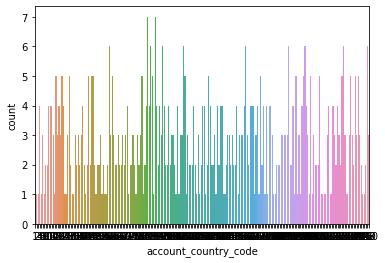

In [50]:
######### 그래프
start = time.time()

pltpath = os.path.join(path, "graph/")
sg = SetGraph(df, table, stat, pltpath)
sg.dcp_distribution_graph(sheet5)
sg.dcp_scale_comparison(sheet6)
#sg.dcp_heatmap(num, sheet7)
print("그래프 time :", time.time() - start)


In [51]:
######### 명세서
stat_col = ['테이블명','항목설명','항목명','항목형식','설명','사용코드','비고']
sheet7.append(stat_col)
for r in dataframe_to_rows(stat, index=False, header=False):
    sheet7.append(r)

In [52]:
######### 코드표
code_col = ['사용코드','사용변수','변수설명','비고']
sheet8.append(code_col)
for r in dataframe_to_rows(code, index=False, header=False):
    sheet8.append(r)

In [53]:
######### 보고서 저장
wb.save(result_report_file_path)